In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

Set up the dataset from our generator:

In [27]:
# Whether or not to load a model. If False/0, create a new model.
# If positive integer, load that most recent model (1=most recent, 2=second-most recent, etc.)
load_model = 2

# Which checkpoint to load (int):
checkpoint_num = 249

In [28]:
def get_sample(fpath):
    audio = np.load(fpath, mmap_mode='r', allow_pickle=True)
    shape = audio.shape
    start_idx = tf.random.uniform(shape=[], minval=0, maxval=shape[0] - 259, dtype=tf.dtypes.int32)
    audio = audio[start_idx:start_idx+259]
    return audio

In [29]:
batch_size = 64
tracks = pd.read_csv('./data/processed_genres_mel.csv')

# Parse filepaths
track_fpaths = list(tracks['fpath'])
track_fpaths = ['./data/fma_medium' + fpath for fpath in track_fpaths]

# Set up train and test data
data = (track_fpaths, list(tracks['parent_genre_id']))
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=len(track_fpaths), seed=1, reshuffle_each_iteration=False)

# Define the split ratio for train/test datasets
num_train_samples = int(0.8 * len(track_fpaths))
num_test_samples = len(track_fpaths) - num_train_samples

# Split into train and test datasets
train_dataset = dataset.take(num_train_samples)
test_dataset = dataset.skip(num_train_samples)

train_dataset = train_dataset.repeat().shuffle(buffer_size=num_train_samples,
                                               reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.repeat().shuffle(buffer_size=num_test_samples,
                                             reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Get the labels for each class:

In [30]:
labels = list(tracks.groupby('parent_genre_id').first().parent_genre_title)

# Re-organize by genre popularity in dataset
labels = [labels[idx] for idx in [2, 6, 4, 0, 3, 14, 1, 7, 12, 13, 5, 11, 8, 10, 9, 15]]

Find the path for the requested model:

In [31]:
# Get the current saving/loading folder
if load_model > 0 and isinstance(load_model, int):
    training_dir_list = os.listdir('./training/')
    training_dir_list.sort()
    save_dir = './training/' + training_dir_list[-load_model]
else:
    raise ValueError("Incorrect model loading integer (see load_model var)")

Path(save_dir).mkdir(parents=True, exist_ok=True)

print(f"Model loading path: {save_dir}")

Model loading path: ./training/training_2023_12_04_19_36_09


Get the correct checkpoint:

In [32]:
checkpoint_path = save_dir + "/cp-" + str(checkpoint_num).zfill(4) + ".ckpt"

Build the model, loading the weights from the checkpoint:

In [33]:
f = open(save_dir + '/model.json', "r")
config = f.read()
model = tf.keras.models.model_from_json(config)
f.close()

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["acc"], optimizer='adam')

model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 600)              1029600   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 128)               76928     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
Total params: 1,108,592
Trainable params: 1,108,592
Non-trainable params: 0
______________________________________________

Predict on the test set:

In [34]:
iterator = iter(test_dataset)
y_test = []
y_pred = []
for _ in tqdm(range(num_test_samples // batch_size)):
    cur_batch = iterator.get_next()
    # First get the labels
    for genre in list(cur_batch[1].numpy()):
        y_test.append(genre)
    
    specs = np.empty((64, 259, 128))
    # Next, extract the predictions
    for idx, fpath in enumerate(list(cur_batch[0].numpy())):
        specs[idx] = get_sample(fpath)
    pred_batch = model.predict(specs, verbose=0)
    pred_batch = np.squeeze(np.array(pred_batch.argmax(axis=1)))
    for pred in pred_batch:
        y_pred.append(pred)

  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 77/77 [03:16<00:00,  2.55s/it]


Construct a confusion matrix:

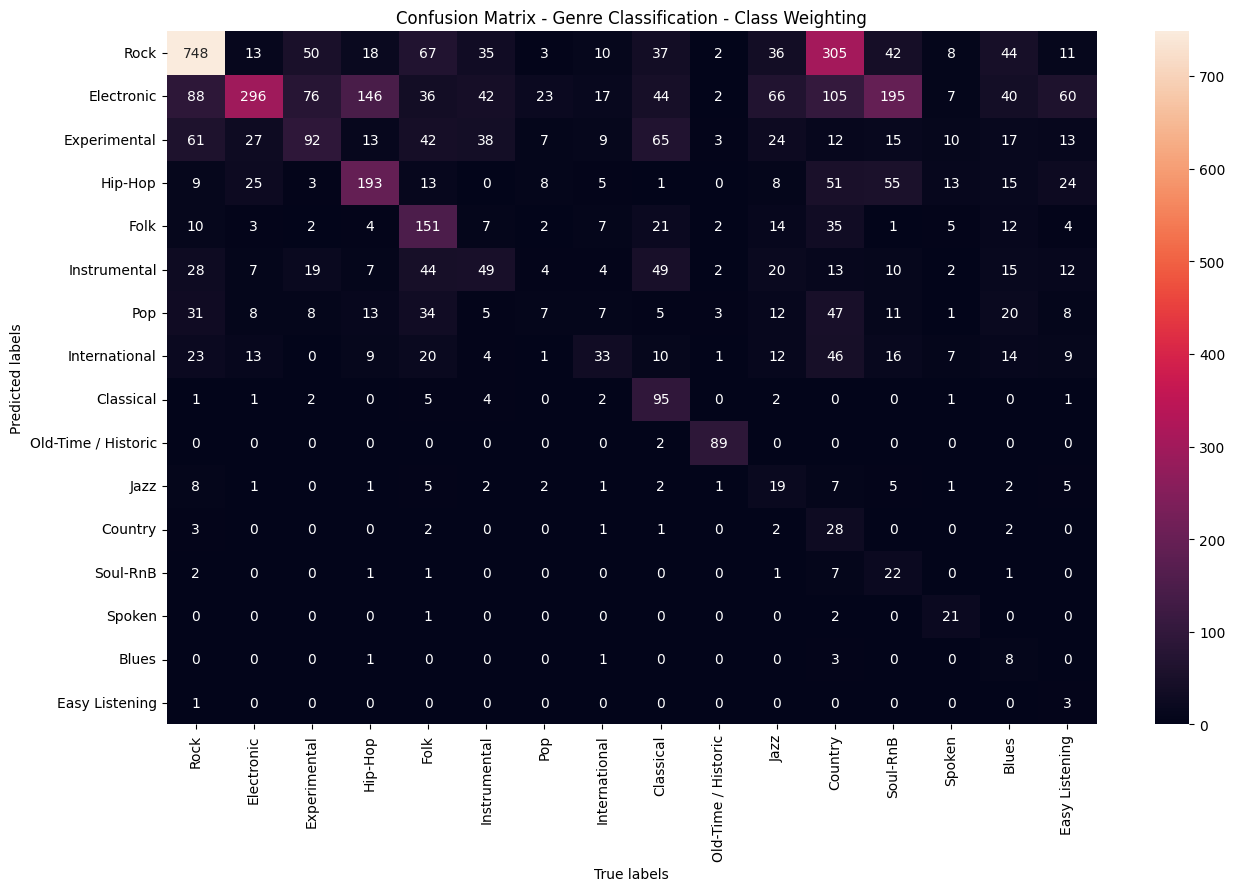

In [35]:
cm = confusion_matrix(y_test, y_pred)

# Re-organize by genre popularity in dataset
cm = cm[[2, 6, 4, 0, 3, 14, 1, 7, 12, 13, 5, 11, 8, 10, 9, 15]]
cm = cm[:, [2, 6, 4, 0, 3, 14, 1, 7, 12, 13, 5, 11, 8, 10, 9, 15]]


# Plot the CM
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(cm, annot=True, fmt='g')
ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix - Genre Classification - Class Weighting') 
ax.xaxis.set_ticklabels(labels, rotation=90)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.savefig('./visualizations/weight_confusion.png', bbox_inches='tight')
plt.show()

In [36]:
from sklearn import metrics
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision: {metrics.precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {metrics.recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {metrics.f1_score(y_test, y_pred, average='weighted')}")

Accuracy: 0.3762175324675325
Precision: 0.5593583742137668
Recall: 0.3762175324675325
F1 Score: 0.412789263460107
